# Keras implementations: example with spiral dataset

* callbacks (EarlyStopping, ModelCheckpoint)
* batch normalization
* dropout

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import keras
import warnings
from mpl_toolkits import mplot3d
from matplotlib import cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_s_curve
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [ ]:
# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# We need to generate two sets of data
def spirals(points, noise=1.5):
    n = np.sqrt(np.random.rand(points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(points),np.ones(points))))
X, y = spirals(1000)

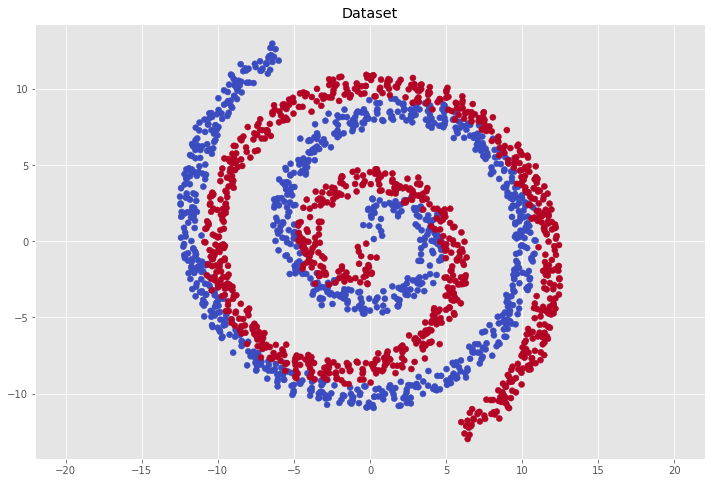

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0], X[:,1], c=y ,cmap=cm.coolwarm)
plt.title('Dataset')
plt.axis('equal');

In [ ]:
print('X:\t{}' .format(X.shape))
print('y:\t{}' .format(y.shape))
print(type(X))
print(type(y))

# Spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# Checking the shape of the input data
print('X_train:\t{}' .format(X_train.shape))
print('y_train:\t{}' .format(y_train.shape))
print('X_valid:\t\t{}'.format(X_valid.shape))
print('y_valid:\t\t{}'.format(y_valid.shape))
print('X_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))


X:	(2000, 2)
y:	(2000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
X_train:	(1400, 2)
y_train:	(1400,)
X_valid:		(300, 2)
y_valid:		(300,)
X_test:		(300, 2)
y_test:		(300,)


### Model definition

In [ ]:
# Hyperparameters
training_epochs = 1000 # Total number of training epochs
learning_rate = 0.005 # The learning rate


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# create a model
def create_model(dropout=0, batchnorm=0):
      tf.keras.backend.clear_session()
      tf.random.set_seed(42)

      model = Sequential()
      # Input layer

      model.add(Dense(20, input_dim=2, kernel_initializer='normal', activation='relu'))
      if dropout:
        model.add(Dropout(dropout, seed=42))
      if batchnorm:
        model.add(BatchNormalization())
      model.add(Dense(10,activation='relu'))
      if dropout:
        model.add(Dropout(dropout, seed=42))
      if batchnorm:
        model.add(BatchNormalization())
      # Output layer
      model.add(Dense(1, activation='sigmoid'))

      # Compile a model
      model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate), 
                    metrics=['accuracy'])
      return model

In [ ]:
def display_history_and_eval(model, results, title=""):

  # summarize history for accuracy
  plt.figure(figsize = (12,5))
  plt.subplot(121)
  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='down right')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(results.history['loss'])
  plt.plot(results.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')

  plt.suptitle(title)

  max_loss = np.max(results.history['loss'])
  min_loss = np.min(results.history['loss'])
  print("Maximum Loss : {:.4f}".format(max_loss))
  print("")
  print("Minimum Loss : {:.4f}".format(min_loss))
  print("")
  print("Loss difference : {:.4f}".format((max_loss - min_loss)))


  ## The model can generate output predictions for the input samples.
  #prediction_values = model.predict(X_test)
  #print("Prediction values shape:", prediction_values.shape)
  ## Turn predicted probabilities into classes:
  #prediction_values = np.round(prediction_values).astype(int)

  # Now we can check the accuracy of our model
  print("\nEvaluating on training set...")
  (loss, accuracy) = model.evaluate(X_train, y_train)
  print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

  print("\nEvaluating on testing set...")
  (loss, accuracy) = model.evaluate(X_test, y_test)
  print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

In [ ]:
def run_model(dropout=0, batchnorm=False, earlystop=False, modelcheckpoint=False, ):
  
  ## create and compile our model
  model = create_model(dropout=dropout, batchnorm=batchnorm)
  print(model.summary(), "\n")
  
  ##############################
  ## the list of callbacks to do at the end of each epoch
  callbacks = []

  if earlystop:
    ##############################
    ## callback for early stopping
    early_stopping_callback = EarlyStopping(
                                            monitor='val_accuracy',
                                            patience=earlystop,
                                            mode='max',
                                            restore_best_weights=True,
                                        )
    callbacks.append(early_stopping_callback)

  if modelcheckpoint:
    ##############################
    ## callback for model checkpoint
    checkpoint_filepath = '/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
                                              filepath=checkpoint_filepath,
                                              save_weights_only=True,
                                              monitor='val_loss',
                                              mode='auto',
                                              save_best_only=True,
                                              )
    '''Note: if not saving weight only, you save the whole model. 
    You can then load the saved model with keras's load_model function
    (instead of loading the weights into an existing model with model.load_weights() ).
    '''
    callbacks.append(model_checkpoint_callback)

  # Let's train the model
  results = model.fit(
            X_train, y_train,
            epochs= training_epochs,
            batch_size = 512,
            validation_data = (X_valid, y_valid),
            verbose = 0, # We need this, because Colab does not like if we print 1000 lines. So we disable keras status prints
            callbacks = callbacks,
            )
  
  ## If we use modelcheckpoint callback, load the saved weights into the model
  if modelcheckpoint:
    model.load_weights(checkpoint_filepath)

  ## display the history and evaluation
  display_history_and_eval(model, results, 
                           title=f"dropout={dropout}, batchnorm={batchnorm}, earlystop={earlystop}, modelcheckpoint={modelcheckpoint}")
  
  return model, results

#### "Baseline": No dropout, BN or earlystopping

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None 

Maximum Loss : 0.7258

Minimum Loss : 0.0853

Loss difference : 0.6405

Evaluating on training set...
44/44 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9671
loss=0.0865, accuracy: 96.7143%

Evaluating on testing set...
10/10 [==============================] - 0s 3ms/step - loss: 0.1

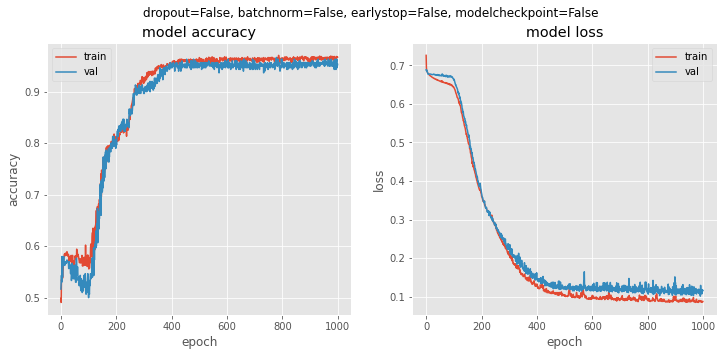

In [ ]:
%%time
model, results = run_model(dropout=False, batchnorm=False, earlystop=False, modelcheckpoint=False, )

#### With BatchNorm after each hidden layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 341
Non-trainable pa

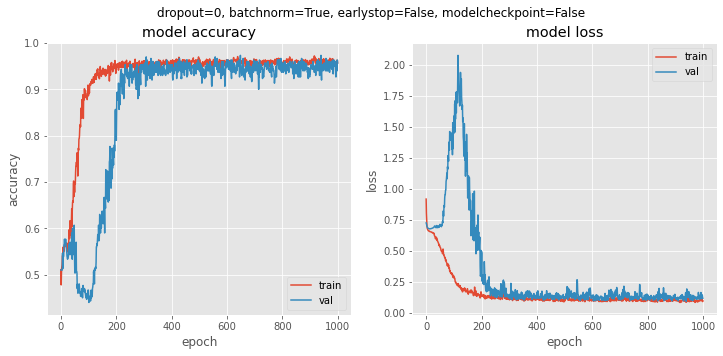

In [ ]:
model, results = run_model(dropout=0, batchnorm=True, earlystop=False, modelcheckpoint=False, )

Batchnorm speeded up training (compared to "baseline").

#### BatchNorm with Early stopping (restoring best weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 341
Non-trainable pa

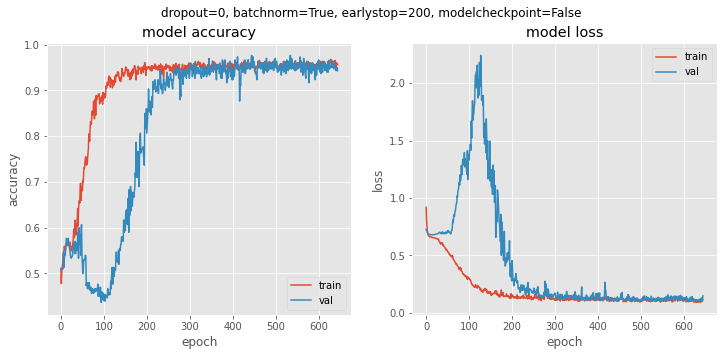

In [ ]:
model, results = run_model(dropout=0, batchnorm=True, earlystop=200, modelcheckpoint=False, )

#### Dropout with Early stopping (restoring best weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None 

Maximum Loss : 0.7398

Minimum Loss : 0.3789

Loss 

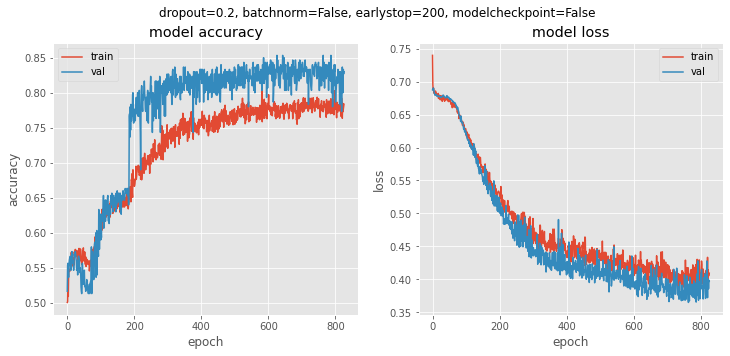

In [ ]:
model, results = run_model(dropout=0.2, batchnorm=False, earlystop=200, modelcheckpoint=False, )

#### Dropout withOUT Early stopping

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None 

Maximum Loss : 0.7398

Minimum Loss : 0.3849

Loss 

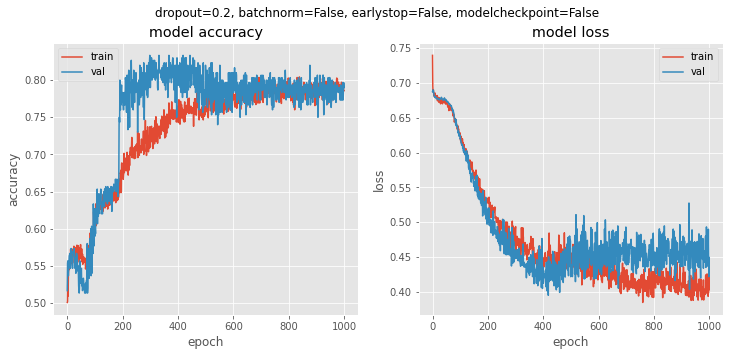

In [ ]:
model, results = run_model(dropout=0.2, batchnorm=False, earlystop=False, modelcheckpoint=False, )

Dropout slows down training (compared to "baseline"). Possibly with more epochs (paying attention to overfitting, the validation loss has already increased!) --- or, conversely, with smaller earlystopping patience and hence less epochs! --- we could reach smaller losses.